# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sb
from bayes_opt import BayesianOptimization
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from imblearn.over_sampling import SMOTE

# Pre-Process Data

Import the dataset

In [3]:
print("Reading file: ", "combine_data_with_labels_new.csv")
df = pd.read_csv('combine_data_with_labels_new.csv')

Reading file:  combine_data_with_labels_new.csv


Select revelant weather conditions affecting the flight performance.

In [4]:
data = df[['HourlyAltimeterSetting', 'HourlyDewPointTemperature', 'HourlyDryBulbTemperature',
           'HourlyPrecipitation', 'HourlyRelativeHumidity', 'HourlySeaLevelPressure', 'HourlyStationPressure', 
           'HourlyVisibility', 'HourlyWetBulbTemperature', 'HourlyWindSpeed']]

Choose Label3 as the target for prediction and encode the target values to numeric types.
Create an additional dictionary storing the inital target values mapped with encoded values.

In [6]:
le = preprocessing.LabelEncoder()
le.fit(df['Label3'])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print('\n Inital target values mapped with encoded values: \n',le_name_mapping)


 Inital target values mapped with encoded values: 
 {'delay': 0, 'delay>15': 1, 'delay>30': 2, 'delay>60': 3, 'ontime': 4}


# XGBoost for Multi-Classification

## Loading data into DMatrices
In order to use the native API for XGBoost, we will first need to build DMatrices. XGBoost likes DMatrices because it's a structure optimized for memory efficiency and training speed

In [7]:
df['Label3'] = le.fit_transform(df['Label3'])

#split data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(data, df.Label3, test_size=0.2, random_state=0)

#convert training and test sets into DMatrices 
train = xgb.DMatrix(x_train, label=y_train)
test = xgb.DMatrix(x_test, label=y_test)


## Apply Bayesian Optimization for tuning hyperparameters using HYPEROPT library

In [8]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
space={'max_depth': hp.quniform("max_depth", 8, 15, 1),
       'subsample': hp.uniform('subsample', 0.5, 1),
       'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
       'min_child_weight' : hp.quniform('min_child_weight', 0, 5, 1),
       'n_estimators': 180}

In [9]:
# Classifier:
def hyperparameter_tuning(space):
    model = xgb.XGBClassifier(n_estimators =space['n_estimators'], 
                              max_depth = int(space['max_depth']), 
                              min_child_weight=space['min_child_weight'],
                              subsample=space['subsample'],
                              colsample_bytree=space['colsample_bytree'])
    evaluation = [( x_train, y_train), ( x_test, y_test)]
    
    model.fit(x_train, y_train,
            eval_set=evaluation, eval_metric="mlogloss",
            early_stopping_rounds=10,verbose=False)

    pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, pred)
    print ("SCORE:", accuracy)
    #change the metric if you like
    return {'loss': -accuracy, 'status': STATUS_OK, 'model': model}

In [10]:
trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print("The best hyperparameters are : ","\n")
print (best)

SCORE:                                                 
0.9820914781941514                                     
SCORE:                                                                               
0.9824663888259194                                                                   
SCORE:                                                                               
0.9824634825419523                                                                   
SCORE:                                                                               
0.9823879191588052                                                                   
SCORE:                                                                               
0.9818328189210711                                                                   
SCORE:                                                                               
0.9823995442946739                                                                   
SCORE:                      

SCORE:                                                                                
0.9823850128748379                                                                    
SCORE:                                                                                
0.9826087967403119                                                                    
SCORE:                                                                                
0.9828325806057858                                                                    
SCORE:                                                                                
0.9827715486424747                                                                    
SCORE:                                                                                
0.9827541109386716                                                                    
SCORE:                                                                                
0.9821757604292                            

## Train XGBoost Model with the tuned hyperparameters

In [11]:
# Tuned hyperparameters
param = {
    'max_depth':15,
    'min_child_weight':2,
    'subsample': 0.998,
    'colsample_bytree': 0.886,
    'eval_metric': 'mlogloss',
    'objective': 'multi:softmax',
    'num_class': 5}
n_estimators = 180

print('\nOptimal Hyperparameters for model training: \n', param, 
      '\nThe number of rounds for boosting: ', n_estimators)

print('Start training model')
model = xgb.train(param, train, n_estimators , evals=[(test, "Test")], early_stopping_rounds=10)
print('Finish training model')


Optimal Hyperparameters for model training: 
 {'max_depth': 15, 'min_child_weight': 2, 'subsample': 0.998, 'colsample_bytree': 0.886, 'eval_metric': 'mlogloss', 'objective': 'multi:softmax', 'num_class': 5} 
The number of rounds for boosting:  180
Start training model
[0]	Test-mlogloss:0.96912
Will train until Test-mlogloss hasn't improved in 10 rounds.
[1]	Test-mlogloss:0.67549
[2]	Test-mlogloss:0.49262
[3]	Test-mlogloss:0.36997
[4]	Test-mlogloss:0.28454
[5]	Test-mlogloss:0.22406
[6]	Test-mlogloss:0.18072
[7]	Test-mlogloss:0.14932
[8]	Test-mlogloss:0.12649
[9]	Test-mlogloss:0.10995
[10]	Test-mlogloss:0.09794
[11]	Test-mlogloss:0.08922
[12]	Test-mlogloss:0.08283
[13]	Test-mlogloss:0.07824
[14]	Test-mlogloss:0.07492
[15]	Test-mlogloss:0.07259
[16]	Test-mlogloss:0.07085
[17]	Test-mlogloss:0.06967
[18]	Test-mlogloss:0.06887
[19]	Test-mlogloss:0.06832
[20]	Test-mlogloss:0.06798
[21]	Test-mlogloss:0.06779
[22]	Test-mlogloss:0.06765
[23]	Test-mlogloss:0.06760
[24]	Test-mlogloss:0.06758
[25]

In [20]:
print("Best mlogloss: {:.2f} with {} rounds".format(model.best_score, model.best_iteration+1))

Best mlogloss: 0.07 with 25 rounds


## Train the XGBoost model with optimal hyperparameters

In [ ]:
print('Start training model')
best_model = xgb.train(param, train, n_estimators, evals=[(test, "Test")])
print('Finish training model')

## Perform Prediction with XGBoost model

In [21]:
print('Start prediction')
predictions = model.predict(test)
print('Finish prediction')
print('Accuracy Score:', accuracy_score(y_test,predictions))

Start prediction
Finish prediction
Accuracy Score: 0.9828936125690969


### Classification Report

In [22]:
class_report = classification_report(y_test, predictions, target_names=['delay', 'delay>15', 'delay>30', 
                                                                        'delay>60', 'ontime'])
print ('\n*Classification Report:\n', class_report)


*Classification Report:
               precision    recall  f1-score   support

       delay       0.16      0.03      0.06       622
    delay>15       0.23      0.09      0.13      1149
    delay>30       0.40      0.24      0.30      2124
    delay>60       0.64      0.54      0.58      3992
      ontime       0.99      1.00      0.99    336195

    accuracy                           0.98    344082
   macro avg       0.48      0.38      0.41    344082
weighted avg       0.98      0.98      0.98    344082



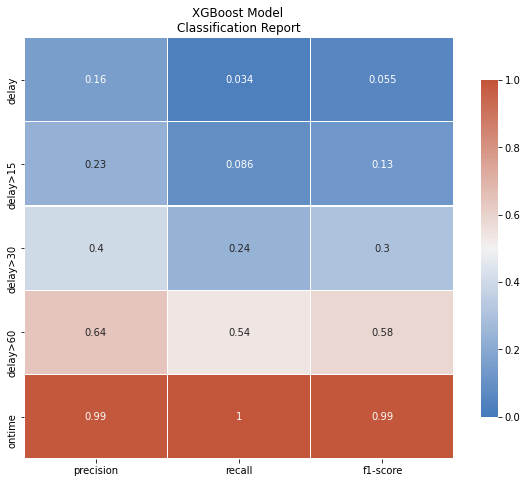

In [23]:
# Plot heatmap for Classification Report
report = classification_report(y_test, predictions, target_names=['delay', 'delay>15', 'delay>30', 
                                                                  'delay>60', 'ontime'], output_dict = True)
rp = pd.DataFrame(report).transpose()

rp = rp.iloc[:5,:3]

cmap = sb.diverging_palette(250, 20, as_cmap=True)
plt.subplots(figsize=(8, 8)) 
heat_map = sb.heatmap(rp, cmap=cmap, annot=True, vmax=1, vmin=0, center=0.5, 
                      square=False, linewidths=.3, cbar_kws={"shrink": .8})
heat_map.figure.tight_layout()
heat_map.figure.subplots_adjust(bottom = 0.25)
plt.title('XGBoost Model \nClassification Report')
plt.show()

### Confusion Matrix

In [24]:
#Create a confusion matrix to see how the model performed in classifying for each cluster
cm = confusion_matrix(y_test, predictions)
print('\nConfusion Matrix: \n', cm)


Confusion Matrix: 
 [[    21     46     60     82    413]
 [    21     99    184    168    677]
 [    18    115    511    500    980]
 [    30     70    325   2138   1429]
 [    45     93    192    438 335427]]


In [25]:
#Neutralize the confusion matrix and convert it to dataframe
cm_neu = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cmtx = pd.DataFrame(cm_neu, 
                    index=['delay', 'delay>15', 'delay>30', 'delay>60', 'ontime'], 
                    columns=['delay', 'delay>15', 'delay>30', 'delay>60', 'ontime'])
print(cmtx)

             delay  delay>15  delay>30  delay>60    ontime
delay     0.033762  0.073955  0.096463  0.131833  0.663987
delay>15  0.018277  0.086162  0.160139  0.146214  0.589208
delay>30  0.008475  0.054143  0.240584  0.235405  0.461394
delay>60  0.007515  0.017535  0.081413  0.535571  0.357966
ontime    0.000134  0.000277  0.000571  0.001303  0.997716


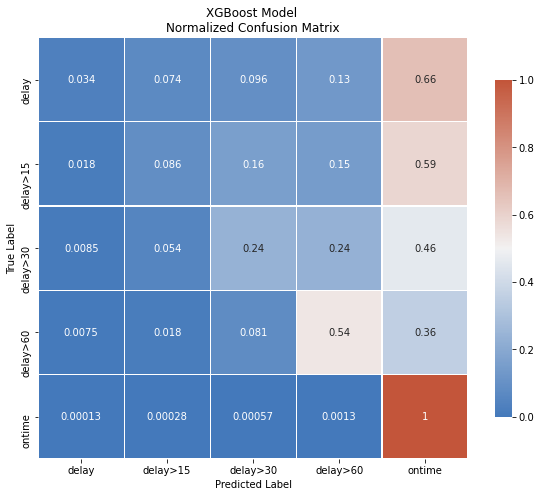

In [26]:
# Plot heatmap for Confusion Matrix
plt.subplots(figsize=(8, 8)) 
heat_map = sb.heatmap(cmtx, cmap=cmap, annot=True, vmax=1, vmin=0, center=0.5, 
                      square=False, linewidths=.3, cbar_kws={"shrink": .8})
heat_map.figure.tight_layout()
heat_map.figure.subplots_adjust(bottom = 0.25)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('XGBoost Model \nNormalized Confusion Matrix')
plt.show()

### Feature Importance

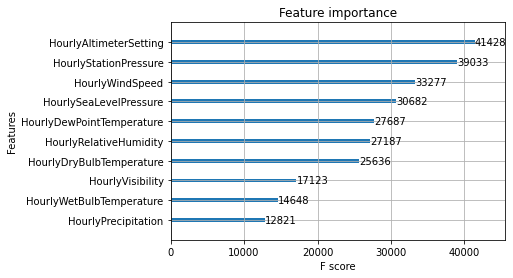

In [28]:
plot_importance(model)
plt.show()